# Prediction du Taux de Grippe en France - Challenge Kaggle

## Contexte du projet

L'objectif de ce challenge est de predire le taux de grippe hebdomadaire par region en France. On dispose de donnees historiques de 2004 a 2014, et on doit predire les semaines suivantes.

C'est un probleme de **regression temporelle** avec une forte composante saisonniere : la grippe suit des cycles annuels bien connus (pics en hiver, creux en ete).

### Donnees disponibles

- **train.csv** : Taux de grippe par region et par semaine (2004-2014)
- **test.csv** : Semaines a predire
- **Donnees meteorologiques SYNOP** : Temperature, humidite, vent, pression... par station meteo
- **Google Trends** : Recherches "grippe" par region et par mois
- **Population par region** : Donnees demographiques annuelles

La difficulte principale : les donnees externes sont a des granularites differentes (horaire pour la meteo, mensuel pour Google, annuel pour la population) alors qu'on veut predire a la semaine.

In [2]:
# Imports necessaires
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# Configuration des chemins
PROJECT_ROOT = Path('.').resolve()
DATA_DIR = PROJECT_ROOT / 'data'

print(f"Dossier projet: {PROJECT_ROOT}")
print(f"Dossier donnees: {DATA_DIR}")

Dossier projet: /Users/arthurdestribats/Downloads/Projet_ML-main
Dossier donnees: /Users/arthurdestribats/Downloads/Projet_ML-main/data


## 1. Exploration des donnees brutes

Commencons par regarder ce qu'on a dans les fichiers train et test.

In [3]:
# Chargement des donnees
train = pd.read_csv(DATA_DIR / 'train.csv')
test = pd.read_csv(DATA_DIR / 'test.csv')

print("=== TRAIN ===")
print(f"Dimensions: {train.shape}")
print(f"Colonnes: {list(train.columns)}")
print(f"\nPeriode: semaine {train['week'].min()} a {train['week'].max()}")
print(f"Regions: {train['region_code'].nunique()}")
print(f"\nApercu:")
train.head(10)

=== TRAIN ===
Dimensions: (9196, 5)
Colonnes: ['Id', 'week', 'region_code', 'region_name', 'TauxGrippe']

Periode: semaine 200401 a 201152
Regions: 22

Apercu:


,Id,week,region_code,region_name,TauxGrippe
0,5523,201152,42,ALSACE,66
1,5524,201152,72,AQUITAINE,24
2,5525,201152,83,AUVERGNE,91
3,5526,201152,25,BASSE-NORMANDIE,49
4,5527,201152,26,BOURGOGNE,33
5,5528,201152,53,BRETAGNE,50
6,5529,201152,24,CENTRE,30
7,5530,201152,21,CHAMPAGNE-ARDENNE,13
8,5531,201152,94,CORSE,19
9,5532,201152,43,FRANCHE-COMTE,20


=== Statistiques TauxGrippe ===
count    9196.000000
mean       77.554589
std       180.939296
min         0.000000
25%         0.000000
50%        10.000000
75%        59.000000
max      2478.000000
Name: TauxGrippe, dtype: float64


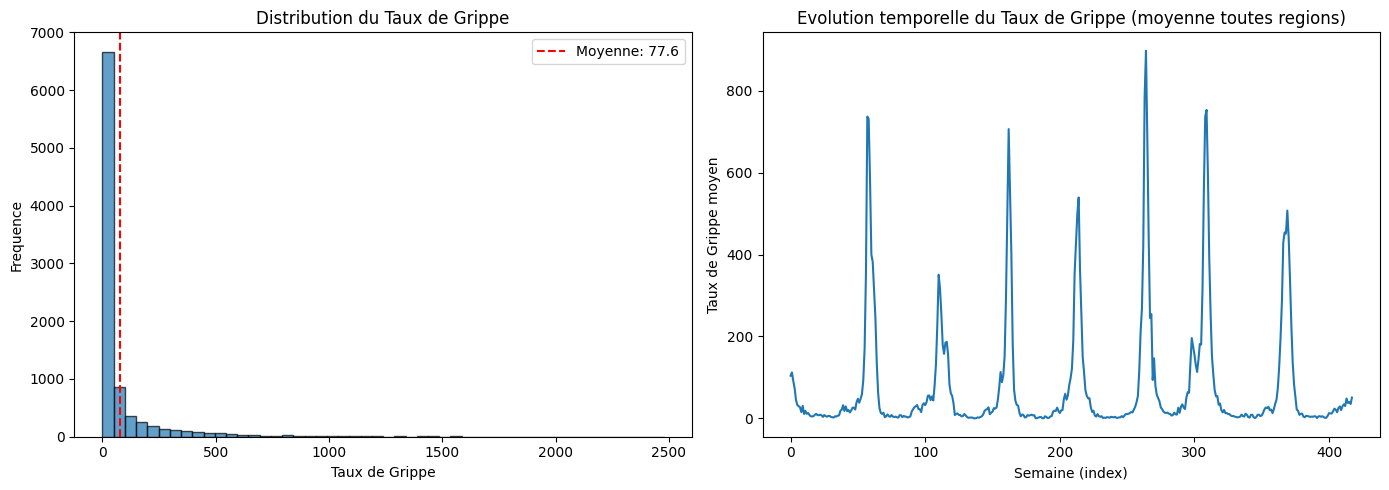


On voit clairement le pattern saisonnier : pics en hiver, creux en ete.


In [4]:
# Statistiques du taux de grippe
print("=== Statistiques TauxGrippe ===")
print(train['TauxGrippe'].describe())

# Visualisation de la distribution
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Histogramme
axes[0].hist(train['TauxGrippe'], bins=50, edgecolor='black', alpha=0.7)
axes[0].set_xlabel('Taux de Grippe')
axes[0].set_ylabel('Frequence')
axes[0].set_title('Distribution du Taux de Grippe')
axes[0].axvline(train['TauxGrippe'].mean(), color='red', linestyle='--', label=f"Moyenne: {train['TauxGrippe'].mean():.1f}")
axes[0].legend()

# Evolution temporelle (moyenne par semaine)
weekly_mean = train.groupby('week')['TauxGrippe'].mean()
axes[1].plot(range(len(weekly_mean)), weekly_mean.values)
axes[1].set_xlabel('Semaine (index)')
axes[1].set_ylabel('Taux de Grippe moyen')
axes[1].set_title('Evolution temporelle du Taux de Grippe (moyenne toutes regions)')

plt.tight_layout()
plt.show()

print("\nOn voit clairement le pattern saisonnier : pics en hiver, creux en ete.")

---

# PARTIE 1 : FUSION DES DONNEES

Avant de construire le modele, on doit fusionner les differentes sources de donnees. C'est la partie la plus technique du projet car chaque source a sa propre granularite temporelle.

## Pipeline de fusion

1. **aggregate_meteo_weekly.py** : Agreger les donnees meteo horaires en hebdomadaire par region
2. **merge_google_trends.py** : Fusionner avec Google Trends (mensuel -> hebdomadaire)
3. **merge_population.py** : Ajouter les donnees de population (annuel -> hebdomadaire via interpolation)

---

## 1.1 Agregation des donnees meteorologiques

Les donnees SYNOP sont des releves horaires de stations meteo. Le probleme : les stations ne correspondent pas directement aux regions administratives.

### Approche adoptee :

1. **Mapper les stations aux regions** : On a cree un dictionnaire manuel qui associe chaque station a sa region
2. **Agreger par semaine et par region** : Pour chaque combinaison (semaine, region), on calcule les statistiques sur toutes les mesures

In [5]:
# Mapping des stations meteo vers les regions
# Extrait du fichier aggregate_meteo_weekly.py

STATION_TO_REGION = {
    # ALSACE (42)
    7190: 42,  # STRASBOURG-ENTZHEIM
    
    # AQUITAINE (72)
    7510: 72,  # BORDEAUX-MERIGNAC
    7607: 72,  # MONT-DE-MARSAN
    
    # AUVERGNE (83)
    7460: 83,  # CLERMONT-FERRAND
    7471: 83,  # LE PUY-LOUDES
    
    # BRETAGNE (53)
    7110: 53,  # BREST-GUIPAVAS
    7117: 53,  # PLOUMANAC'H
    7207: 53,  # BELLE ILE
    7130: 53,  # RENNES
    
    # ILE-DE-FRANCE (11)
    7149: 11,  # ORLY
    
    # RHONE-ALPES (82)
    7481: 82,  # LYON
    7577: 82,  # MONTELIMAR
    
    # ... et ainsi de suite pour les 22 regions
}

print(f"Exemple de mapping:")
print(f"  Station 7149 (Orly) -> Region 11 (Ile-de-France)")
print(f"  Station 7510 (Bordeaux) -> Region 72 (Aquitaine)")

Exemple de mapping:
  Station 7149 (Orly) -> Region 11 (Ile-de-France)
  Station 7510 (Bordeaux) -> Region 72 (Aquitaine)


In [6]:
# Variables meteorologiques agregees par semaine
# Pour chaque variable, on calcule plusieurs statistiques

meteo_aggregations = {
    'temperature': ['mean', 'min', 'max', 'std'],  # Celsius (convertie depuis Kelvin)
    'point_de_rosee': ['mean'],                      # Indicateur d'humidite
    'humidite': ['mean', 'min', 'max'],             # Pourcentage
    'vitesse_vent': ['mean', 'max'],                # m/s
    'pression': ['mean'],                            # hPa
    'precipitations': ['sum', 'mean', 'max']        # mm
}

print("Variables meteorologiques calculees:")
for var, stats in meteo_aggregations.items():
    print(f"  {var}: {', '.join(stats)}")

print("\nNote: La temperature dans les fichiers SYNOP est en Kelvin.")
print("On la convertit en Celsius: T(C) = T(K) - 273.15")

Variables meteorologiques calculees:
  temperature: mean, min, max, std
  point_de_rosee: mean
  humidite: mean, min, max
  vitesse_vent: mean, max
  pression: mean
  precipitations: sum, mean, max

Note: La temperature dans les fichiers SYNOP est en Kelvin.
On la convertit en Celsius: T(C) = T(K) - 273.15


## 1.2 Fusion avec Google Trends

Google Trends fournit un indice de recherche pour le mot "grippe" par region et par mois. Le probleme : nos donnees sont hebdomadaires, pas mensuelles.

### Solution : Attribution du mois via le jeudi de la semaine ISO

La norme ISO definit qu'une semaine appartient a l'annee qui contient son jeudi. On utilise la meme logique pour le mois : chaque semaine est associee au mois de son jeudi.

In [7]:
from datetime import datetime, timedelta

def week_to_month(week_id):
    """
    Convertit un identifiant de semaine YYYYWW en mois YYYY-MM.
    
    On prend le mois du JEUDI de la semaine (standard ISO).
    """
    year = week_id // 100
    week = week_id % 100
    
    # Le 4 janvier est toujours dans la semaine 1 (norme ISO)
    jan4 = datetime(year, 1, 4)
    
    # Trouver le lundi de la semaine 1
    week1_monday = jan4 - timedelta(days=jan4.weekday())
    
    # Calculer le lundi de la semaine demandee
    target_monday = week1_monday + timedelta(weeks=week - 1)
    
    # Le jeudi de cette semaine
    target_thursday = target_monday + timedelta(days=3)
    
    return target_thursday.strftime('%Y-%m')

# Exemples
print("Exemples de conversion semaine -> mois:")
for week_id in [200401, 200405, 200452, 201201]:
    print(f"  Semaine {week_id} -> Mois {week_to_month(week_id)}")

Exemples de conversion semaine -> mois:
  Semaine 200401 -> Mois 2004-01
  Semaine 200405 -> Mois 2004-01
  Semaine 200452 -> Mois 2004-12
  Semaine 201201 -> Mois 2012-01


In [8]:
# Mapping des noms de fichiers Google vers les noms de regions
# Les fichiers Google ont des noms sans accents ni tirets

FILENAME_TO_REGION = {
    'Alsace': 'ALSACE',
    'Aquitaine': 'AQUITAINE',
    'BasseNormandie': 'BASSE-NORMANDIE',
    'Bretagne': 'BRETAGNE',
    'CentreValdeLoire': 'CENTRE',
    'IledeFrance': 'ILE-DE-FRANCE',
    'ProvenceAlpesCotedAzur': 'PROVENCE-ALPES-COTE-D-AZUR',
    'RhoneAlpes': 'RHONE-ALPES',
    # ... etc pour les 22 regions
}

print("Les fichiers Google Trends contiennent 3 colonnes:")
print("  - google_grippe : recherches 'grippe' brutes")
print("  - google_grippe_no_aviaire : sans 'grippe aviaire'")
print("  - google_grippe_filtered : version filtree (celle qu'on utilise)")

Les fichiers Google Trends contiennent 3 colonnes:
  - google_grippe : recherches 'grippe' brutes
  - google_grippe_no_aviaire : sans 'grippe aviaire'
  - google_grippe_filtered : version filtree (celle qu'on utilise)


## 1.3 Ajout des donnees de population

Les donnees de population sont annuelles (une valeur par region par an). Pour les utiliser a la semaine, on fait une **interpolation par spline cubique**.

### Pourquoi une spline cubique ?

- L'interpolation lineaire donnerait des "cassures" au 1er janvier de chaque annee
- La spline cubique assure une transition lisse entre les annees
- C'est plus realiste car la population evolue progressivement

### Donnees de population disponibles

- Population totale
- Population par tranche d'age : 0-19, 20-39, 40-59, 60-74, 75+

On calcule aussi des ratios utiles :
- **pop_ratio_elderly** : proportion de 60+ ans (population a risque pour la grippe)
- **pop_ratio_75_plus** : proportion de 75+ ans (tres a risque)

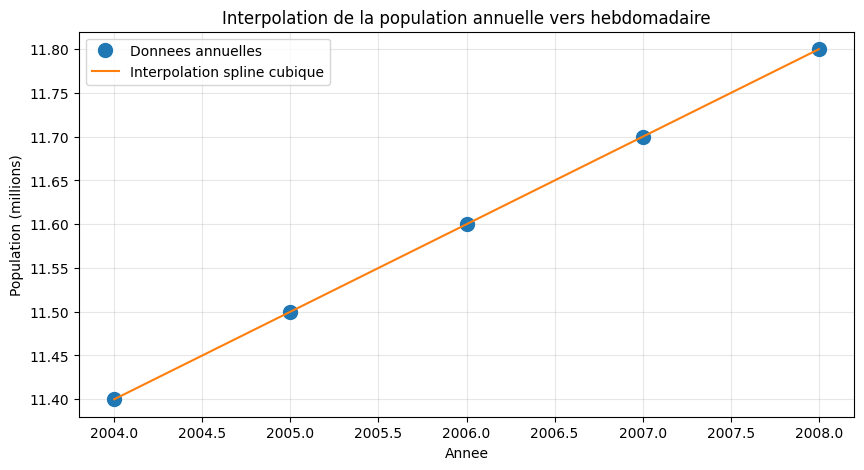

La spline cubique permet une transition lisse entre les annees.


In [9]:
# Illustration de l'interpolation par spline cubique
from scipy.interpolate import CubicSpline

# Exemple avec des donnees fictives
years = np.array([2004, 2005, 2006, 2007, 2008])
pop_idf = np.array([11.4, 11.5, 11.6, 11.7, 11.8])  # Population IDF en millions (fictif)

# Creer la spline
cs = CubicSpline(years, pop_idf)

# Interpoler pour chaque semaine
x_interp = np.linspace(2004, 2008, 200)
y_interp = cs(x_interp)

plt.figure(figsize=(10, 5))
plt.plot(years, pop_idf, 'o', markersize=10, label='Donnees annuelles')
plt.plot(x_interp, y_interp, '-', label='Interpolation spline cubique')
plt.xlabel('Annee')
plt.ylabel('Population (millions)')
plt.title('Interpolation de la population annuelle vers hebdomadaire')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

print("La spline cubique permet une transition lisse entre les annees.")

## 1.4 Resultat : le fichier enrichi

Apres toutes ces fusions, on obtient un fichier `train_enrichi.csv` (et `test_enrichi.csv`) qui contient pour chaque ligne (semaine, region) :

| Categorie | Variables |
|-----------|-----------|
| **Cible** | TauxGrippe |
| **Identifiants** | week, region_code, region_name |
| **Google Trends** | google_grippe, google_grippe_filtered |
| **Meteo** | temp_mean, temp_min, temp_max, humidity_mean, wind_speed_mean, pressure_mean, precipitation_sum, ... |
| **Population** | pop_total, pop_0_19, pop_20_39, pop_40_59, pop_60_74, pop_75_plus, pop_ratio_elderly |

---

# PARTIE 2 : FEATURE ENGINEERING

Maintenant qu'on a les donnees fusionnees, on va creer des features supplementaires pour capturer les patterns temporels et saisonniers.

## 2.1 Features temporelles et saisonnalite

La grippe suit un cycle annuel tres regulier. On encode cette saisonnalite de plusieurs facons :

### Encodage sinusoidal

On transforme le numero de semaine (1-52) en coordonnees sur un cercle :
- `sin_1 = sin(2*pi*week/52)` 
- `cos_1 = cos(2*pi*week/52)`

Pourquoi ? Parce que la semaine 52 est proche de la semaine 1 (fin decembre ~ debut janvier), et cette representation capture bien cette circularite.

### Flag saison grippale

On cree aussi un indicateur binaire `is_flu_season` qui vaut 1 pendant la saison grippale (semaines 45 a 12, soit novembre a mars).

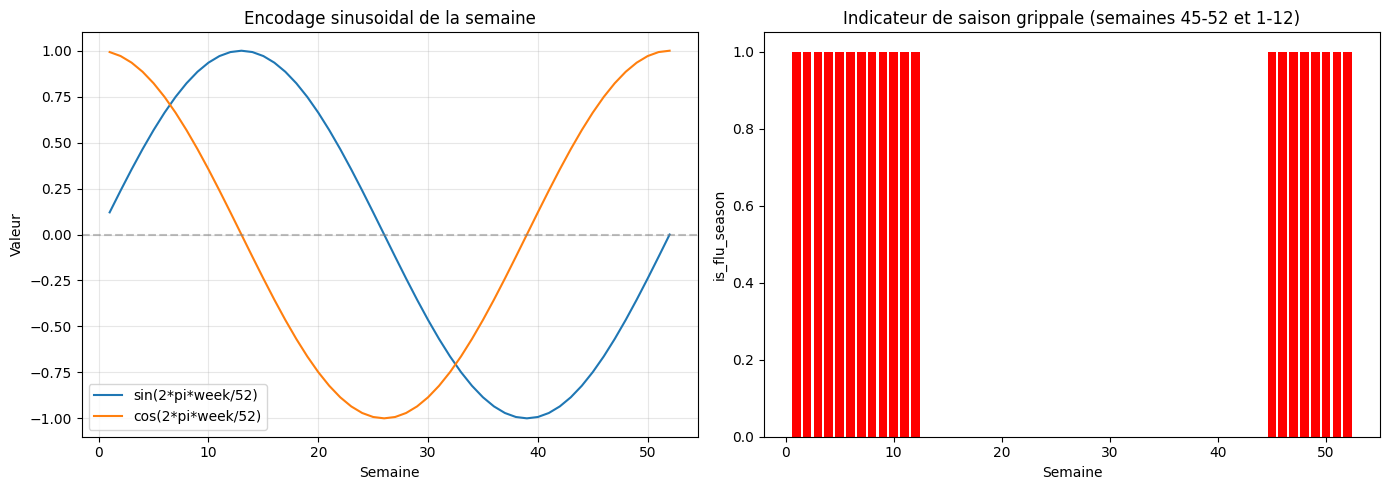

In [10]:
# Illustration de l'encodage sinusoidal
weeks = np.arange(1, 53)

sin_1 = np.sin(2 * np.pi * weeks / 52)
cos_1 = np.cos(2 * np.pi * weeks / 52)
is_flu_season = ((weeks <= 12) | (weeks >= 45)).astype(int)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Sinusoides
axes[0].plot(weeks, sin_1, label='sin(2*pi*week/52)')
axes[0].plot(weeks, cos_1, label='cos(2*pi*week/52)')
axes[0].axhline(0, color='gray', linestyle='--', alpha=0.5)
axes[0].set_xlabel('Semaine')
axes[0].set_ylabel('Valeur')
axes[0].set_title('Encodage sinusoidal de la semaine')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Flag saison grippale
axes[1].bar(weeks, is_flu_season, color=['red' if x else 'lightgray' for x in is_flu_season])
axes[1].set_xlabel('Semaine')
axes[1].set_ylabel('is_flu_season')
axes[1].set_title('Indicateur de saison grippale (semaines 45-52 et 1-12)')

plt.tight_layout()
plt.show()

## 2.2 Features de lag (retard temporel)

C'est la **feature la plus importante** du modele. L'idee : le taux de grippe de cette semaine depend fortement du taux de la semaine precedente.

- **taux_lag1** : Taux de grippe de la semaine precedente (t-1)
- **taux_lag2** : Taux de grippe il y a 2 semaines (t-2)
- **taux_diff1** : Difference entre lag1 et lag2 (tendance)

### Pourquoi c'est crucial ?

La grippe se propage progressivement. Si beaucoup de gens etaient malades la semaine derniere, il y a de fortes chances qu'il y en ait encore beaucoup cette semaine. C'est de l'auto-correlation temporelle.

In [11]:
# Illustration des lags
# On prend une region et quelques semaines

sample_data = train[train['region_code'] == 11].sort_values('week').head(20).copy()
sample_data['taux_lag1'] = sample_data['TauxGrippe'].shift(1)
sample_data['taux_lag2'] = sample_data['TauxGrippe'].shift(2)

print("Exemple de lags pour l'Ile-de-France:")
print(sample_data[['week', 'TauxGrippe', 'taux_lag1', 'taux_lag2']].head(10).to_string(index=False))

print("\nOn voit que taux_lag1 est simplement le TauxGrippe decale d'une ligne.")

Exemple de lags pour l'Ile-de-France:
  week  TauxGrippe  taux_lag1  taux_lag2
200401          66        NaN        NaN
200402          74       66.0        NaN
200403          88       74.0       66.0
200404          26       88.0       74.0
200405          17       26.0       88.0
200406          25       17.0       26.0
200407          22       25.0       17.0
200408           4       22.0       25.0
200409           2        4.0       22.0
200410          28        2.0        4.0

On voit que taux_lag1 est simplement le TauxGrippe decale d'une ligne.


## 2.3 Features d'historique regional

Pour chaque combinaison (region, numero de semaine dans l'annee), on calcule des statistiques sur les annees passees :

- **rw_mean** : Taux moyen historique pour cette semaine de l'annee dans cette region
- **rw_median** : Taux median historique
- **rw_std** : Ecart-type historique (variabilite)
- **rw_max** : Taux maximum historique

### Intuition

La semaine 5 en Ile-de-France a historiquement un certain niveau de grippe. Cette information aide le modele a se calibrer.

In [12]:
# Calcul des statistiques historiques
train_copy = train.copy()
train_copy['week_num'] = train_copy['week'].astype(str).str[4:].astype(int)

# Statistiques par (region, semaine de l'annee)
hist_stats = train_copy.groupby(['region_code', 'week_num'])['TauxGrippe'].agg([
    'mean', 'median', 'std', 'max'
]).reset_index()
hist_stats.columns = ['region_code', 'week_num', 'rw_mean', 'rw_median', 'rw_std', 'rw_max']

print("Statistiques historiques pour l'Ile-de-France (region 11):")
print(hist_stats[hist_stats['region_code'] == 11].head(15).to_string(index=False))

print("\nOn voit que la semaine 5 a historiquement un taux plus eleve que la semaine 30 (ete).")

Statistiques historiques pour l'Ile-de-France (region 11):
 region_code  week_num  rw_mean  rw_median     rw_std  rw_max
          11         1  176.875      127.5 154.895760     496
          11         2  168.875      123.0 117.645275     314
          11         3  180.125      210.0  98.054558     310
          11         4  198.125      225.5 122.098833     350
          11         5  231.500      227.0 165.389583     522
          11         6  247.500      236.0 188.460682     529
          11         7  236.625      146.0 238.649736     645
          11         8  167.750      135.5 162.380286     417
          11         9  136.125       72.0 172.163907     520
          11        10   94.625       45.5 104.413926     314
          11        11   76.375       44.5  79.545023     228
          11        12   75.125       48.5  70.747918     208
          11        13   48.000       22.5  54.221767     167
          11        14   19.125       15.0  10.273927      33
          1

## 2.4 Features Google Trends

On transforme les donnees Google Trends pour les rendre plus exploitables :

- **google_log** : Logarithme des recherches Google (reduit l'effet des valeurs extremes)
- **google_x_rw** : Interaction entre Google et l'historique regional

### Pourquoi le logarithme ?

Les recherches Google peuvent avoir des pics tres importants. Le log "compresse" ces valeurs extremes et rend la distribution plus normale.

## 2.5 Features d'interaction

Les features d'interaction combinent deux informations pour en creer une nouvelle plus riche :

- **lag1_x_season** : taux_lag1 * is_flu_season
  - Amplifie le lag en saison grippale, le reduit hors saison
  
- **lag1_x_google** : taux_lag1 * google_log
  - Combine le taux recent avec les recherches Google
  - Si les deux sont eleves, la feature explose -> forte grippe

Ces interactions permettent au modele de capturer des effets non-lineaires.

## 2.6 Resume : Les 15 features du modele V12

Apres experimentation, on a garde les 15 features les plus importantes :

| Rang | Feature | Importance | Description |
|------|---------|------------|-------------|
| 1 | taux_lag1 | 23.4% | Taux semaine precedente |
| 2 | lag1_x_season | 23.4% | Lag x saison grippale |
| 3 | rw_max | 13.9% | Maximum historique |
| 4 | lag1_x_google | 13.7% | Lag x Google |
| 5 | rw_std | 10.4% | Variabilite historique |
| 6 | taux_diff1 | 5.2% | Tendance (lag1 - lag2) |
| 7 | google_log | 2.6% | Log des recherches Google |
| 8 | taux_lag2 | 1.6% | Taux il y a 2 semaines |
| 9 | google_x_rw | 1.5% | Google x historique |
| 10 | cos_1 | 1.4% | Cosinus semaine |
| 11 | sin_1 | 0.7% | Sinus semaine |
| 12 | rw_median | 0.7% | Median historique |
| 13 | cos_2 | 0.5% | 2eme harmonique |
| 14 | rw_mean | 0.4% | Moyenne historique |
| 15 | is_flu_season | 0.3% | Flag saison |

**Observation cle** : Les 5 premieres features representent 82% de l'importance totale. Le lag et ses interactions dominent largement.

---

# PARTIE 3 : MODELISATION

## 3.1 Choix du modele : CatBoost

On utilise **CatBoost**, un algorithme de gradient boosting developpe par Yandex. Pourquoi ce choix ?

### Avantages de CatBoost

1. **Gestion native des variables categoriques** : La region est une variable categorique (11, 21, 22...). CatBoost la gere directement sans encodage one-hot.

2. **Robuste a l'overfitting** : CatBoost utilise des techniques comme "ordered boosting" pour reduire le surapprentissage.

3. **Performant** : Tres bon sur les donnees tabulaires, souvent meilleur que XGBoost et LightGBM.

4. **Rapide a entrainer** : Optimise pour les CPU modernes.

## 3.2 Hyperparametres et regularisation

Le modele V12 utilise une **regularisation forte** pour eviter l'overfitting :

```python
model = CatBoostRegressor(
    iterations=500,           # Nombre d'arbres
    learning_rate=0.06,       # Pas d'apprentissage modere
    depth=4,                  # Arbres peu profonds (evite overfitting)
    l2_leaf_reg=12,           # Regularisation L2 forte
    min_data_in_leaf=60,      # Minimum 60 observations par feuille
    random_strength=2.5,      # Ajout de bruit aleatoire
    bagging_temperature=0.8,  # Sous-echantillonnage des donnees
    early_stopping_rounds=25  # Arret si pas d'amelioration
)
```

### Explication des parametres cles

- **depth=4** : Des arbres peu profonds generalisent mieux. Un arbre trop profond apprend "par coeur" les donnees d'entrainement.

- **l2_leaf_reg=12** : Penalise les poids trop grands dans les feuilles. Force le modele a rester simple.

- **min_data_in_leaf=60** : Chaque decision doit etre basee sur au moins 60 observations. Evite les decisions basees sur trop peu de donnees.

- **early_stopping** : On arrete l'entrainement si le score de validation ne s'ameliore plus pendant 25 iterations.

## 3.3 Strategie de validation

On utilise une **validation temporelle** : on entraine sur les annees 2004-2010 et on valide sur 2011.

Pourquoi pas une validation croisee classique (k-fold) ?

Parce que nos donnees sont **temporelles**. Si on melange les annees dans le train et la validation, on aurait des fuites d'information : le modele pourrait "voir" le futur pendant l'entrainement.

La validation temporelle simule le scenario reel : on a des donnees passees et on predit le futur.

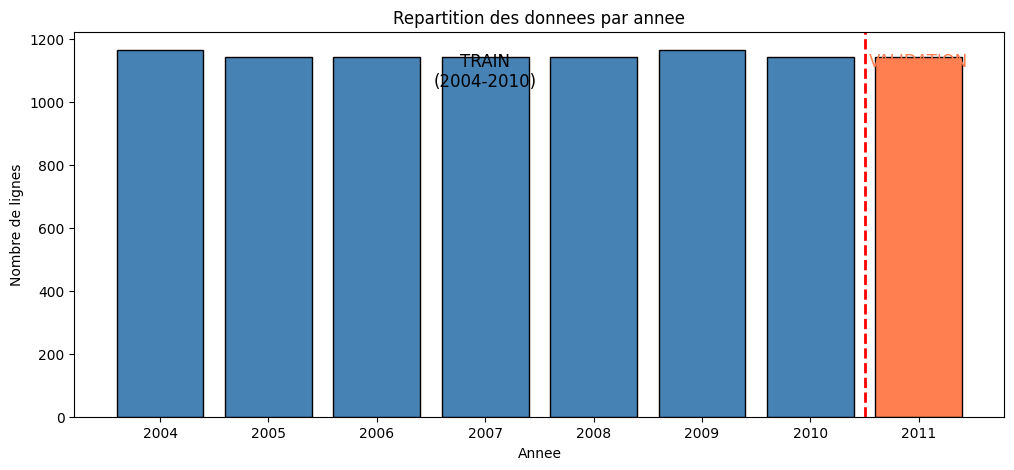

Train: annees 2004-2010 (8052 lignes)
Validation: annee 2011 (1144 lignes)


In [13]:
# Illustration de la validation temporelle
train_years = train.copy()
train_years['year'] = train_years['week'].astype(str).str[:4].astype(int)

year_counts = train_years.groupby('year').size()

plt.figure(figsize=(12, 5))
colors = ['steelblue'] * (len(year_counts) - 1) + ['coral']
plt.bar(year_counts.index, year_counts.values, color=colors, edgecolor='black')
plt.xlabel('Annee')
plt.ylabel('Nombre de lignes')
plt.title('Repartition des donnees par annee')
plt.axvline(2010.5, color='red', linestyle='--', linewidth=2)
plt.text(2007, max(year_counts)*0.9, 'TRAIN\n(2004-2010)', fontsize=12, ha='center')
plt.text(2011, max(year_counts)*0.9, 'VALIDATION\n(2011)', fontsize=12, ha='center', color='coral')
plt.show()

print(f"Train: annees 2004-2010 ({train_years[train_years['year'] < 2011].shape[0]} lignes)")
print(f"Validation: annee 2011 ({train_years[train_years['year'] == 2011].shape[0]} lignes)")

## 3.4 Prediction recursive

Pour la prediction sur le jeu de test, on a un probleme : on utilise le taux de la semaine precedente (taux_lag1) comme feature, mais on ne connait pas ce taux pour les semaines futures !

### Solution : Prediction recursive

On predit semaine par semaine :
1. Semaine 1 du test : on utilise le dernier taux connu du train comme lag1
2. Semaine 2 du test : on utilise la prediction de la semaine 1 comme lag1
3. Et ainsi de suite...

C'est une approche autoregressive : chaque prediction depend des predictions precedentes.

In [14]:
# Schema de la prediction recursive

print("PREDICTION RECURSIVE")
print("=" * 50)
print()
print("Donnees train (connues):")
print("  Semaine 201450: TauxGrippe = 125")
print("  Semaine 201451: TauxGrippe = 142")
print("  Semaine 201452: TauxGrippe = 158  <- derniere valeur connue")
print()
print("Predictions test (inconnues -> a predire):")
print("  Semaine 201501: lag1 = 158 (dernier train) -> prediction = 165")
print("  Semaine 201502: lag1 = 165 (pred S1)       -> prediction = 172")
print("  Semaine 201503: lag1 = 172 (pred S2)       -> prediction = 168")
print("  ...")
print()
print("Risque: les erreurs se propagent de semaine en semaine.")

PREDICTION RECURSIVE

Donnees train (connues):
  Semaine 201450: TauxGrippe = 125
  Semaine 201451: TauxGrippe = 142
  Semaine 201452: TauxGrippe = 158  <- derniere valeur connue

Predictions test (inconnues -> a predire):
  Semaine 201501: lag1 = 158 (dernier train) -> prediction = 165
  Semaine 201502: lag1 = 165 (pred S1)       -> prediction = 172
  Semaine 201503: lag1 = 172 (pred S2)       -> prediction = 168
  ...

Risque: les erreurs se propagent de semaine en semaine.


---

# PARTIE 4 : EXECUTION DU MODELE V12

Maintenant, executons le modele complet et analysons les resultats.

In [16]:
# Chargement des donnees enrichies
# Ces fichiers sont generes par le pipeline de fusion (./setup.sh run)

train_enrichi_path = PROJECT_ROOT / 'train_enrichi.csv'
test_enrichi_path = PROJECT_ROOT / 'test_enrichi.csv'

if not train_enrichi_path.exists():
    print("⚠️  ATTENTION: Les fichiers enrichis n'existent pas encore!")
    print()
    print("Pour les generer, executez dans le terminal:")
    print("  Mac/Linux: ./setup.sh run")
    print("  Windows:   .\\setup.ps1 run")
    print()
    print("Ou executez les scripts de fusion manuellement:")
    print("  python fusion/aggregate_meteo_weekly.py")
    print("  python fusion/merge_google_trends.py")
    print("  python fusion/merge_population.py")
else:
    train_enrichi = pd.read_csv(train_enrichi_path)
    test_enrichi = pd.read_csv(test_enrichi_path)

    print(f"Train enrichi: {train_enrichi.shape}")
    print(f"Test enrichi: {test_enrichi.shape}")
    print(f"\nColonnes disponibles:")
    print(list(train_enrichi.columns))

Train enrichi: (9196, 23)
Test enrichi: (2288, 22)

Colonnes disponibles:
['Id', 'week', 'region_code', 'region_name', 'TauxGrippe', 'temp_mean', 'temp_min', 'temp_max', 'temp_std', 'dewpoint_mean', 'humidity_mean', 'humidity_min', 'humidity_max', 'wind_speed_mean', 'wind_speed_max', 'pressure_mean', 'precipitation_sum', 'precipitation_mean', 'precipitation_max', 'month', 'google_grippe', 'google_grippe_no_aviaire', 'google_grippe_filtered']


In [17]:
from catboost import CatBoostRegressor, Pool
from sklearn.metrics import mean_squared_error

rmse = lambda y, p: np.sqrt(mean_squared_error(y, p))

def create_features_v12(df, hist):
    """Creation des 15 features du modele V12."""
    df = df.copy()
    h = hist.copy()
    
    df['week_num'] = df['week'].astype(str).str[4:].astype(int)
    h['week_num'] = h['week'].astype(str).str[4:].astype(int)
    
    # Saisonnalite
    df['sin_1'] = np.sin(2 * np.pi * df['week_num'] / 52)
    df['cos_1'] = np.cos(2 * np.pi * df['week_num'] / 52)
    df['cos_2'] = np.cos(2 * np.pi * 2 * df['week_num'] / 52)
    df['is_flu_season'] = ((df['week_num'] <= 12) | (df['week_num'] >= 45)).astype(int)
    
    # Historique regional
    agg = h.groupby(['region_code', 'week_num'])['TauxGrippe'].agg([
        'mean', 'median', 'std', 'max'
    ]).reset_index()
    agg.columns = ['region_code', 'week_num', 'rw_mean', 'rw_median', 'rw_std', 'rw_max']
    df = df.merge(agg, on=['region_code', 'week_num'], how='left')
    
    for c in ['rw_mean', 'rw_median', 'rw_std', 'rw_max']:
        df[c] = df[c].fillna(df[c].median() if df[c].notna().any() else 0)
    
    # Google Trends
    df['google'] = df['google_grippe_filtered'].fillna(0)
    df['google_log'] = np.log1p(df['google'])
    df['google_x_rw'] = df['google_log'] * df['rw_mean']
    
    return df

print("Fonction create_features_v12 definie.")

Fonction create_features_v12 definie.


In [18]:
# Preparation des donnees
train_sorted = train_enrichi.sort_values(['region_code', 'week']).reset_index(drop=True)

# Creation des lags
train_sorted['taux_lag1'] = train_sorted.groupby('region_code')['TauxGrippe'].shift(1)
train_sorted['taux_lag2'] = train_sorted.groupby('region_code')['TauxGrippe'].shift(2)

for col in ['taux_lag1', 'taux_lag2']:
    train_sorted[col] = train_sorted[col].fillna(train_sorted[col].median())

# Creation des features
train_f = create_features_v12(train_sorted, train_sorted)
train_f['taux_lag1'] = train_sorted['taux_lag1']
train_f['taux_lag2'] = train_sorted['taux_lag2']

# Interactions
train_f['lag1_x_season'] = train_f['taux_lag1'] * train_f['is_flu_season']
train_f['lag1_x_google'] = train_f['taux_lag1'] * train_f['google_log']
train_f['taux_diff1'] = train_f['taux_lag1'] - train_f['taux_lag2']

print("Features creees.")
print(f"Dimensions: {train_f.shape}")

Features creees.
Dimensions: (9196, 40)


In [19]:
# Liste des 15 features
features = [
    'taux_lag1', 'lag1_x_season', 'rw_max', 'lag1_x_google', 'rw_std',
    'taux_diff1', 'google_log', 'taux_lag2', 'google_x_rw', 'cos_1',
    'sin_1', 'rw_median', 'cos_2', 'rw_mean', 'is_flu_season'
]

# Split temporel
train_f = train_f.sort_values('week').reset_index(drop=True)
train_f['year'] = train_f['week'].astype(str).str[:4].astype(int)
max_year = train_f['year'].max()

train_d = train_f[train_f['year'] < max_year]
val_d = train_f[train_f['year'] == max_year]

X_tr = train_d[features + ['region_code']]
y_tr = train_d['TauxGrippe']
X_va = val_d[features + ['region_code']]
y_va = val_d['TauxGrippe']

print(f"Train: {len(train_d)} lignes (annees < {max_year})")
print(f"Validation: {len(val_d)} lignes (annee {max_year})")

Train: 8052 lignes (annees < 2011)
Validation: 1144 lignes (annee 2011)


In [20]:
# Entrainement du modele
print("Entrainement du modele CatBoost...")
print("(avec early stopping sur la validation)")
print()

model = CatBoostRegressor(
    iterations=500,
    learning_rate=0.06,
    depth=4,
    l2_leaf_reg=12,
    min_data_in_leaf=60,
    random_strength=2.5,
    bagging_temperature=0.8,
    random_seed=42,
    verbose=100,  # Afficher progression tous les 100 arbres
    early_stopping_rounds=25,
    use_best_model=True
)

model.fit(
    Pool(X_tr, y_tr, cat_features=['region_code']),
    eval_set=Pool(X_va, y_va, cat_features=['region_code'])
)

print(f"\nMeilleure iteration: {model.get_best_iteration()}")

Entrainement du modele CatBoost...
(avec early stopping sur la validation)

0:	learn: 176.3237044	test: 159.9744936	best: 159.9744936 (0)	total: 58.9ms	remaining: 29.4s
Stopped by overfitting detector  (25 iterations wait)

bestTest = 69.06561034
bestIteration = 52

Shrink model to first 53 iterations.

Meilleure iteration: 52


RMSE sur validation (annee 2011): 69.07



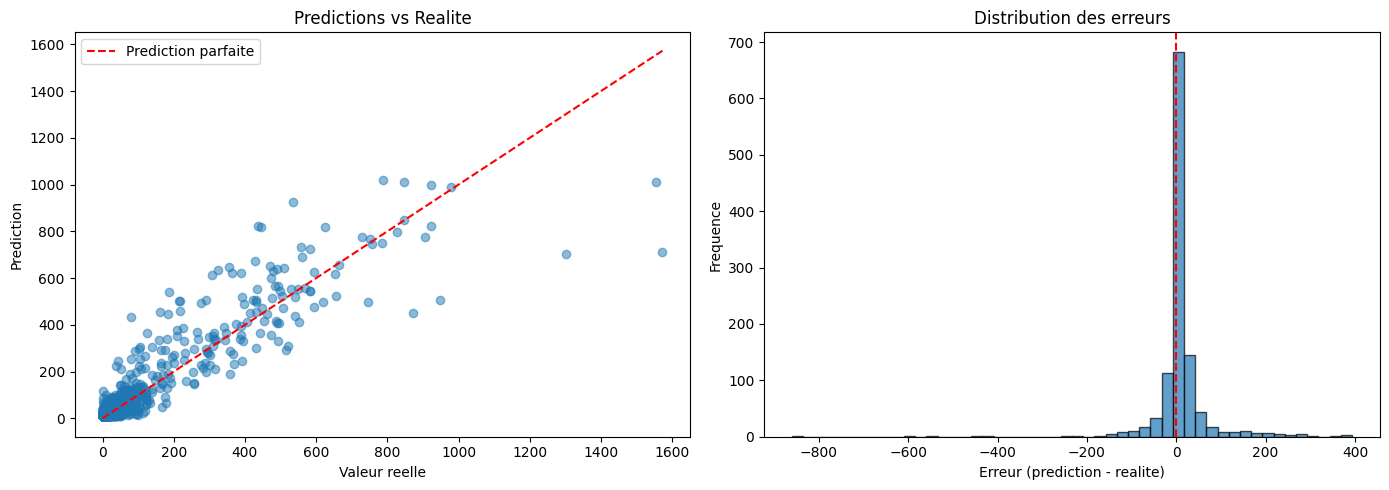

Erreur moyenne: 11.83
Ecart-type des erreurs: 68.08


In [21]:
# Evaluation sur la validation
pred_va = np.clip(model.predict(X_va), 0, None)
val_rmse = rmse(y_va, pred_va)

print(f"RMSE sur validation (annee {max_year}): {val_rmse:.2f}")
print()

# Comparaison predictions vs realite
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Scatter plot
axes[0].scatter(y_va, pred_va, alpha=0.5)
axes[0].plot([0, max(y_va)], [0, max(y_va)], 'r--', label='Prediction parfaite')
axes[0].set_xlabel('Valeur reelle')
axes[0].set_ylabel('Prediction')
axes[0].set_title('Predictions vs Realite')
axes[0].legend()

# Distribution des erreurs
errors = pred_va - y_va
axes[1].hist(errors, bins=50, edgecolor='black', alpha=0.7)
axes[1].axvline(0, color='red', linestyle='--')
axes[1].set_xlabel('Erreur (prediction - realite)')
axes[1].set_ylabel('Frequence')
axes[1].set_title('Distribution des erreurs')

plt.tight_layout()
plt.show()

print(f"Erreur moyenne: {errors.mean():.2f}")
print(f"Ecart-type des erreurs: {errors.std():.2f}")

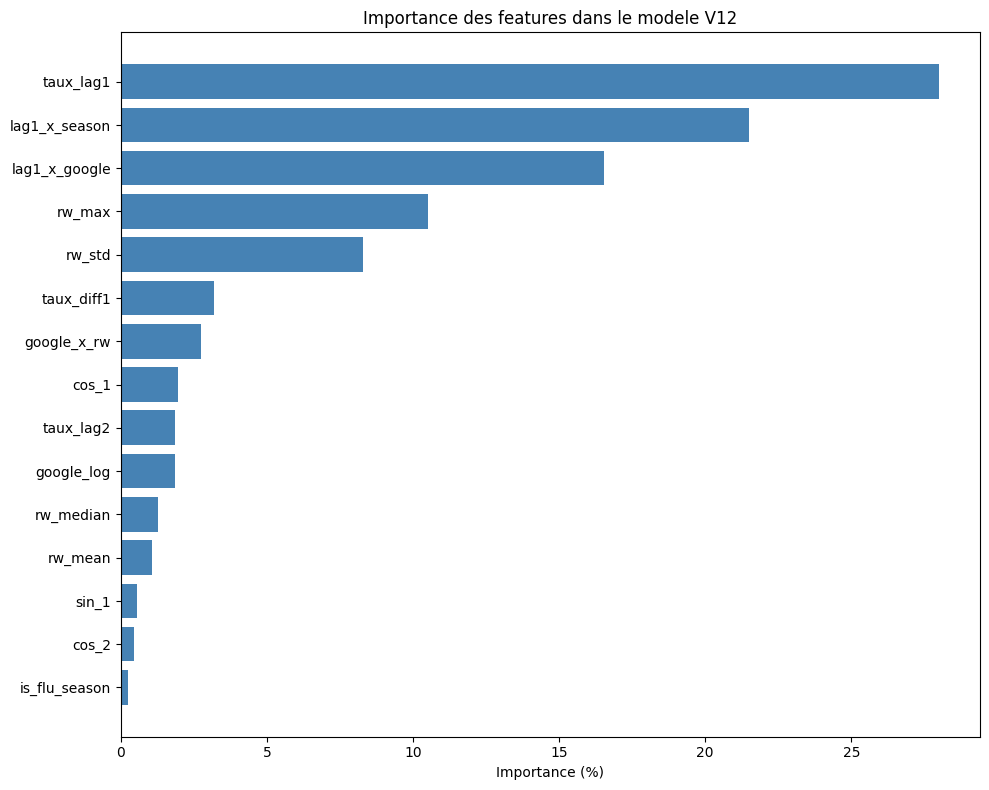

Top 5 features:
  taux_lag1: 28.0%
  lag1_x_season: 21.5%
  lag1_x_google: 16.5%
  rw_max: 10.5%
  rw_std: 8.3%


In [22]:
# Feature importance
feat_imp = pd.DataFrame({
    'feature': features,
    'importance': model.get_feature_importance()[:len(features)]
}).sort_values('importance', ascending=True)

plt.figure(figsize=(10, 8))
plt.barh(feat_imp['feature'], feat_imp['importance'], color='steelblue')
plt.xlabel('Importance (%)')
plt.title('Importance des features dans le modele V12')
plt.tight_layout()
plt.show()

print("Top 5 features:")
for _, row in feat_imp.sort_values('importance', ascending=False).head(5).iterrows():
    print(f"  {row['feature']}: {row['importance']:.1f}%")

---

# PARTIE 5 : CONCLUSIONS


## Pistes d'amelioration

- **Ensembling** : Combiner plusieurs modeles (V12, V13, etc.) pour moyenner les predictions
- **Features meteo** : La temperature pourrait etre utile (grippe plus repandue en hiver froid)
- **Cross-validation temporelle** : Valider sur plusieurs annees, pas juste la derniere
- **Modeles recurrents** : LSTM ou GRU pour capturer les dependances temporelles longues

## Resume du pipeline complet

```
DONNEES BRUTES                           FUSION                              MODELE
============                           =======                              ======

train.csv ─────────────────────────────────┐
                                           │
test.csv ──────────────────────────────────┤
                                           │
DonneesMeteorologiques/ ──► aggregate  ────┼──► train_enrichi.csv ──► create_features ──► CatBoost ──► predictions
  (fichiers horaires)      meteo weekly    │      test_enrichi.csv         (15 features)
                                           │
RequetesGoogleParRegion/ ──► merge  ───────┤
  (fichiers mensuels)      google trends   │
                                           │
Population Excel ──────────► merge  ───────┘
  (donnees annuelles)      population
                           (spline cubique)
```

## Fichiers du projet

| Fichier | Description |
|---------|-------------|
| `fusion/aggregate_meteo_weekly.py` | Agregation des donnees SYNOP |
| `fusion/merge_google_trends.py` | Fusion avec Google Trends |
| `fusion/merge_population.py` | Ajout population (spline) |
| `best_models/V12_15Features.py` | Modele final avec 15 features |
| `config.py` | Configuration des chemins |